# Guide to Experiment 1: RC filters

Métodos da Físcia Experimental I: (F540 2s2021)

* JupyterBook: Gustavo Wiederhecker, Varlei Rodrigues
* Contributions: Daniel Ugarte, Antônio Riul Junior, Varlei Rodrigues

In this experiment, circuits  containing a capacitor and
a resistor will be investigated. These circuits allow us to measure the electric current
(resistor) or the electrical charge (capacitor) that flows in the circuits. The
amplitude and phase of the current or electric charge depend on the frequency. This dependency
motivates their usage and their application as frequency filters, such as 
low-pass or high-pass filters.

To understand this behavior, it is essential to review the concept of
frequency response, that is, as the response of a given system
linear behaves as a function of the excitation frequency, so it is recommended that the student review the subject in the book of their choice. An excelent reference is Denis Eggleston's book  (chapter 2) {cite}`eggleston2011basic`.

:::{admonition} Goals
:class: tip
-   Understand the relationships between sinusoidal voltages and currents in circuits containing resistors, capacitors and inductors.

-   Understand how these circuits can be used as filters of     electrical signals.

- Determine the frequency response of the amplitude and phase of 
     RC filters; low-pass, high-pass

-   Describe the behavior of filters through graphs of
     transmittance and phase on a logarithmic scale (Bode diagrams).
:::



:::{admonition} Items to include in your lab report
:class: warning
1. Graphs of Bode diagrams of the high-pass and low-pass filters. You must generate the graphs, based on the data provided in {ref}`sec:dataset1`.
2. In the same graph as the data, include the curves that represent fitting of the transfer functions. An example of this procedure in Python can be seen in {doc}`exemplo_ajuste_rc`
    * Make sure you can also estimate the asymptotic slopes of the ampitude plots, e.g., what is the filter roll-off in dB/decade? 
    * Based on on the intersection between the asymptotes, provide an estimate of the cut-off frequency of the filter. Estimate the RC constant of the filter based on your estimate, compare with your fitting results.
3. Use the FFT function in Python (or in a program of your choice) to calculate the Fourier transform of two-frequncies signal provided {ref}`sec:dataset2`.
     * The difference between the two signals is that the channel 2 signal was filtered by an RC circuit. Determine whether the circuit used was a high-pass or low-pass.
4. Provide hyperlinks to your TinkerCAD simulation and upload your QUCS file.
:::

In [1]:
#-----------------------------
#Pacote para manipular vetores e matrizes
import numpy as np
import pandas as pd
#-----------------------------
#Pacotes para lidar com unidades
from astropy import units as un
from astropy import constants as cte
#-----------------------------
#pacote para gráficos
import matplotlib.pyplot as plt
import matplotlib
#Comandos opcionais para formatar gráfico
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}	
lines = {'linewidth' : 3.0}
figure = {'figsize' : [6.0, 6/1.6]}
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
matplotlib.rc('figure', **figure)
#-----------------------------
from myst_nb import glue
#pacote para desenhar circuitos
import SchemDraw as schem
import SchemDraw.elements as e
d = schem.Drawing(unit=2.5) # unit=2.5 determina o tamanho dos componentes
# %config InlineBackend.figure_format = 'svg'

## Frequency response of filters

Consider the circuit diagrams shown in the figure below. All are examples of AC voltage dividers that behave as frequency filters.

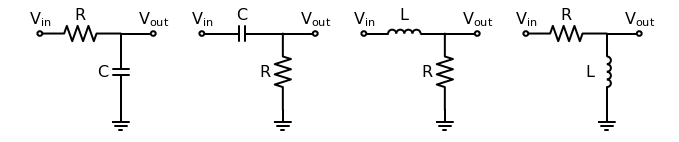

In [14]:
d = schem.Drawing(unit=2.5,)
compsL = [['R','C'],['C','R'],['L','R'],['R','L']]
comps = [[e.RES,e.CAP],[e.CAP,e.RES],[e.INDUCTOR,e.RES],[e.RES,e.INDUCTOR]]
labels = ['RC passa-baixas','RC passa-altas','RL passa-baixas','RL passa-altas']
xy0 = [0,0]
for i,comp in enumerate(compsL):
    comp1 = '$'+comp[0]+'$'
    comp2 = '$'+comp[1]+'$'
    d.add(e.DOT_OPEN, label ='$V_{in}$',xy=xy0)
    comp1 =d.add(comps[i][0], d='right',label=comp1) #capacitor
    d.add(comps[i][1], d='down',label=comp2) # resistor de saída
    d.add(e.GND)
    #output
    d.add(e.LINE, d='right', xy=comp1.end, l=1)
    d.add(e.DOT_OPEN,label ='$V_{out}$')
    xy0[0] += 5
    #---
# fig = d.draw()  
# glue("fig_filtros_diversos", display(d.draw()),display=False)
d.draw()

In the laboratory, a possible implementation of one of these circuits has the aspect of {numref}`foto_filtro_pa`:

```{figure} figs/foto_passa_altas_small.jpg
---
width: 450px
name: foto_filtro_pa
---
Filtro passa-altas montado em uma protoboard.
```

The filtering effect of these circuits can be seen by observing the behavior of the signal with an oscilloscope. For example, the RC high-pass filter  behavior manifests as in the {numref}`highpass_scope`. 

```{figure} figs/sweep_freq_pa.png
---
width: 450px
name: highpass_scope
---
High-pass RC filter (R = 300, C = 470 nF), frequency 10 Hz. The blue trace represents the input signal, while the orange trace represents the output signal.
```

## Measuring amplitude and phase-shifts 

Any electrical circuit whose response depends on the frequency introduces a lag in the output signal relative to the input signal. The low-pass and high-pass filters studied below are two typical examples. The figure below illustrates the input ($ V_ {in} $) and output ($ V_ {out} $) signals associated with a high-pass filter. Note that the signals are not in phase. The value of the $ \phi $ lag can be obtained by measuring the time difference $ \Delta t $ between their zero-crossing voltages.

$$ \phi= 2\ \pi\ \cfrac{\Delta t}{T} $$ (eq:phase)


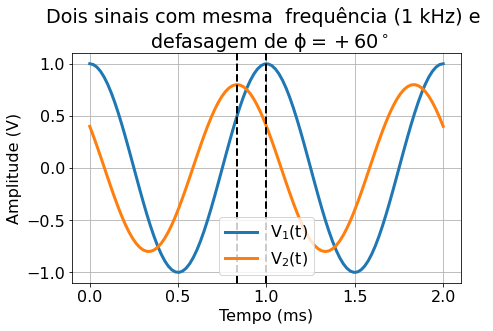

In [15]:
t = np.linspace(0,2e-3,100) # vetor de tempo
f,ϕ1,ϕ2 = 1e3,0,np.pi/3 # frequencia e fase
v01,v02 = 1,0.8 # amplitudes
#----
v1 = v01*np.cos(2*np.pi*f*t+ϕ1) # sinal v1(t)
v2 = v02*np.cos(2*np.pi*f*t+ϕ2) # sinal v2(t)

fig,ax = plt.subplots()
plt.plot(t*1e3, v1, label =r'$V_1(t)$')
plt.plot(t*1e3, v2, label =r'$V_2(t)$')
#----
ϕ = ϕ2-ϕ1 # defasagem
T = 1/f # periodo dos sinais
dt = T*ϕ/(2*np.pi) # atraso temporal entre os sinais
#linhas verticais
plt.axvline(T*1e3,color='k',linestyle='--',linewidth=2.0)
plt.axvline((T-dt)*1e3,color='k',linestyle='--',linewidth=2.0)
#--------
#formatação do gráfico
plt.grid(True) # ativa grades
plt.legend(loc='best')
plt.xlabel('Tempo (ms)')
plt.ylabel('Amplitude (V)')
plt.title('Dois sinais com mesma  frequência (1 kHz) e \n defasagem de $\phi=+{:1g}^\circ$'.format(180*ϕ/np.pi));
glue("fig_fase_exemplo",fig,display=False)
#plt.savefig('sinais_defasados.pdf')

Note that eq. {eq}`eq:phase` allows us to relate the measurement on the oscilloscope (time difference) with the phase difference, as illustrated in {numref}`fig:example_phase`
```{glue:figure} fig_fase_exemplo
:figwidth: 400px
:name: fig:example_phase
:align: center

Example of phase difference between two signals. The phase here is of signal 2 relative to 1, $ \phi = \phi_2- \phi_1 $, therefore, signal 2 is ** ahead ** of 1.
```



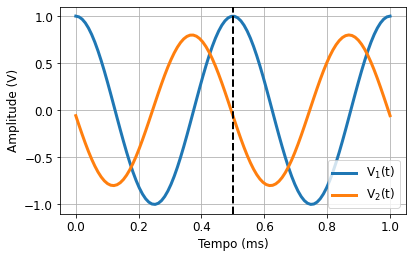

In [29]:
t = np.linspace(0,1e-3,100) # vetor de tempo
f,ϕ1,ϕ2 = 2e3,0, np.pi/2+ np.pi/3*np.random.randn()  # frequencia e fase
v01,v02 = 1,0.8 # amplitudes
#----
v1 = v01*np.cos(2*np.pi*f*t+ϕ1) # sinal v1(t)
v2 = v02*np.cos(2*np.pi*f*t+ϕ2) # sinal v2(t)
plt.plot(t*1e3, v1, label =r'$V_1(t)$')
plt.plot(t*1e3, v2, label =r'$V_2(t)$')
#----
ϕ = ϕ2-ϕ1 # defasagem
T = 1/f # periodo dos sinais
dt = T*ϕ/(2*np.pi) # atraso temporal entre os sinais
#linhas verticais
plt.axvline(T*1e3,color='k',linestyle='--',linewidth=2.0)
# plt.axvline((T-dt)*1e3,color='k',linestyle='--',linewidth=2.0)
#--------
#formatação do gráfico
plt.grid(True) # ativa grades
plt.legend(loc='best')
plt.xlabel('Tempo (ms)')
plt.ylabel('Amplitude (V)')
# plt.title('Dois sinais com mesma defasagem de $\phi$'.format(180*ϕ/np.pi));
plt.tight_layout()
plt.savefig('figs/ex_delta_fase.png', bbox_inches='tight')
#plt.savefig('sinais_defasados.pdf')

````{exercise} Phase difference between signals
:label: ex:fase_delta1

Consider the following figure and determine:

```{image} figs/ex_delta_fase.png
:alt: circuit picture
:width: 400px
:align: center
```
* the frequency of the signals
* the phase difference between the signals
```` 

````{solution} ex:fase_delta1
:label: exs:fase_delta1

To solve this problem, first calculate the time difference between the waves, then use the eq. {eq}`eq:phase` to find the phase difference.

````

````{exercise} Phase difference between signals on the oscilloscope
: label: ex:fase_delta2

Considering the oscilloscope screen that was captured using an RC circuit:

```{image} figs/sweep_freq_pa.png
:alt: oscilloscope traces
:width: 400px
:align: center
```
* The amplitude $ v_j \pm \delta v_j $ ([V]) of each signal;
* The frequency $ f $ [1/s] and angular frequency $ \omega $ [rad/s] of the signals;
* The phase difference between the signals, $ \phi = \phi_2- \phi_1 $, consider the phase signal!
* Based on the calculated phase, indicate whether is it a low-pass or high-pass filter? Justify.
```` 

## RC filters: high-pass (HP) and low-pass (LP)

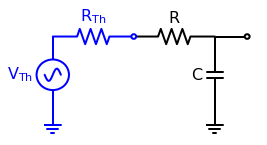

In [34]:
d = schem.Drawing(unit=2.5)
#fonte
source_color='blue' # cor da fonte
d.add(e.GND,color=source_color) # terra
d.add(e.SOURCE_SIN, label='$V_{Th}$', color=source_color) # fonte
d.add(e.RES, d='right',label='$R_{Th}$', color=source_color)
d.add(e.DOT_OPEN, color=source_color)
#circuito
diode1 =d.add(e.RES, d='right',label='$R$') #capacitor
d.add(e.CAP, d='down',label='$C$') # resistor de saída
d.add(e.GND)
#output
d.add(e.LINE, d='right', xy=diode1.end, l=1)
d.add(e.DOT_OPEN)
#---
d.draw()
d.save('figs/filtro_pb_esquema.png')

The circuit below illustrates a filter case where the low frequency signals have their amplitudes attenuated, while high frequency signals are transmitted almost without attenuation. Mount the high-pass filter using $R = 300 $ \Omega $, $C = 470$ nF.
```{figure} figs/filtro_pb_esquema.png
---
width: 300px
name: fig:filter_pb_scheme
---
Schematic of a low-pass filter.
```

The transfer function$ H (\omega) $  or voltage gain $ G (\omega) $ are defined as,

$$
G(\omega)=H(\omega)=\cfrac{V_{out}}{V_{in}}=\cfrac{v_{out}\exp(j\phi_{out})}{v_{in}\exp(j\phi_{in})}=\cfrac{v_{out}}{v_{in}}\exp(j\phi),
$$(eq:gain)

where $ v_{out, in} $ represents the amplitudes and $ \phi \equiv \phi_ {out} - \phi_ {in} $ the phase difference.

Experimentally, the amplitudes and phase difference are measured separately, as done in the exercise {numref}`ex:fase_delta2`. As the eq. {eq}`eq:gain` contains information about the amplitude and phase of the signals, it will be represented by two graphs (Bode diagram).
One for the amplitude,

$$
G_{dB} = 10\log_{10}(|G(\omega)|^2) = 20\log_{10}\left(\cfrac{V_{out}^{(pp)}}{V_{in}^{(pp)}}\right)
$$ (eq:bode_gdb_experimental)

and the other for the phase difference,

$$
\phi = \arg(G(\omega))=\arg\left(\cfrac{v_{out}}{v_{in}}\exp(j\phi)\right)=\phi
$$ (eq:bode_phi_experimental)

### Preparation for the experiment

````{exercise} Preparação para experimento
:label: ex:prep_exp1

* Demonstrate the transfer function (voltage gain) for this circuit. Use complex impedances for this.
* What is the circuit cutoff frequency ?.
* How it behaves (total impedance and output voltage).
* With a minimum of math, try to see how the phase of the $ V_ {out} $ signal changes from $ V_ {in} $.
* What effect does $ R_ {th} $ have on the circuit response? Does it change the measure of $ V_ {out} (f) $, $ V_ {in} (f) $ and $ V_ {out} (f) / V_ {in} (f) $?

Circuit simulation:
* Use TinkerCAD to assemble the circuit of the figure {numref}`fig:filter_pb_scheme`, investigate its behavior.
* Use QUCS to explore the behavior.

```` 

### Acquiring experimental data

```{warning}
Due to COVID-19 campus access restrictions, data acquisition will not take place in 1s2021!
```


Use the signal generator to analyze the behavior of and of the $ \ phi $ phase for the cutoff frequency, the frequency a decade below the cutoff frequency and the frequency a decade above the cutoff frequency.
* Using the pylab acquire the values of $ V_ {in} $, frequency, $ V_ {out} $ and $ \ phi $ for a range of frequency values. Use $ V_ {in} $ = 2 V ($ V_ {in} ^ {pp} = 1 $ V) for the amplitude of the input signal.

```{note}
* In the program, the values must be defined:
     * initial frequency = 10 Hz
     * final frequency = 100 kHz
     * points = 30
* Before using 30 points, scan with 10 points to make sure everything is correct.
```

In [1]:
data = pd.read_csv('figs/dados_sweep.csv')
glue("df_pandas_exemplo", data.head())

NameError: name 'pd' is not defined

(sec:dataset1)=
### Downloadable dataset 1
* The data made available in Teams were obtained following the parameters above.
* Three files (.zip):
    * [Low-pass circuit](https://github.com/gwiederhecker/F540_jbook/blob/2021_2s/guides/exp1/dados/passa-baixas.zip?raw=true)
    * [High-pass circuit](https://github.com/gwiederhecker/F540_jbook/blob/2021_2s/guides/exp1/dados/passa-altas.zip?raw=true)
        * Each `.zip` file contains:
         * `.jpg` file with a photo of the circuit
         * file `data_sweep.csv`: see an example of the structure of this file below.
         * 4 columns
         * the phase (column `phase (degrees)` corresponds to $ \phi = \phi_2- \phi_1 $)
         * folder `traces-temporal-images`:
             * files with the name `sweep_freq_xxx.bmp` correspond to the scope traces used to calculate each of the parameters of the file` data_sweep.csv`. The `xxx` numbering of the` .bmp` files corresponds to the index available in the first column of the `data_sweep.csv` file
             * Make sure that you can "read" the data from one of the `sweep_freq_xxx.bmp` files and get the corresponding result recorded in the` data_sweep.csv` file.

````{tabbed} Frequency reponse data example
```{glue:figure} df_pandas_exemplo
:figwidth: 600px
:name: "tbl:pandas"
:align: center

Structure of the `.csv` data file, the separator between entries is a comma (`,`).
```
````
````{tabbed} Examples oscilloscope screenshot
```{figure} figs/sweep_freq_pa.png
---
width: 450px
name: "fig:highpass_scope_exemplo"
---
Screenshot of the oscilloscope for the high-pass with $ f = 10 $ Hz!
```
````

### An application of a high-pass filter

f1 = 1000.0 Hz
f2 = 500.0 Hz
f0 = (f1+f2)/2 = 750.0 Hz
δf = (f1-f2) = 500.0 Hz


'Sinal composto por duas ondas senoidais. \n $f_1$=1000 Hz e $f_2$=500 Hz'

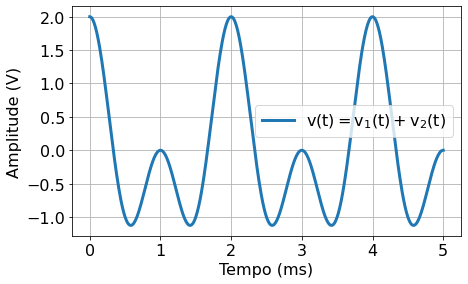

In [17]:
t = np.linspace(0,5e-3,500) # vetor de tempo
f1,f2= 1e3,0.5e3 # frequencia e fase
v01,v02 = 1,1 # amplitudes
print('f1 = {} Hz'.format(f1))
print('f2 = {} Hz'.format(f2))
print('f0 = (f1+f2)/2 = {} Hz'.format(0.5*(f1+f2)))
print('δf = (f1-f2) = {} Hz'.format(np.abs(f1-f2)))
#----
v1 = v01*np.cos(2*np.pi*f1*t) # sinal v1(t)
v2 = v02*np.cos(2*np.pi*f2*t) # sinal v2(t)
#----
fig,ax = plt.subplots()
plt.plot(t*1e3, v1+v2, label= '$v(t)=v_1(t)+v_2(t)$')
#--------
#formatação do gráfico
plt.grid(True) # ativa grades
plt.legend(loc='best')
plt.xlabel('Tempo (ms)')
plt.ylabel('Amplitude (V)')
glue("fig_dois_sinais",fig,display=False)
#plt.savefig('sinais_defasados.pdf')

A very important real application of filters is to eliminate an undesired frequency component of an electrical signal. For example, it could a residue from the AC-line frequency (60 Hz) that could be contaminating an audio output from your stereo system. Let's assume a given signal has only two frequencies componentes,

$$v(t) = v_{01} \cos(2\pi f_1 t)+v_{02} \cos(2\pi f_2 t).$$ (eq:soma_tensao)

In the time domain this signal can be viewed as shown in the figure below.

```{glue:figure} fig_dois_sinais
:figwidth: 450px
:name: "fig:dois_sinais"
:align: center

Signal composed of two sine waves. $ f_1 $ = 1000 Hz and $ f_2 $ = 500 Hz
```

<!-- Como veremos, nosso gerador de funções BK-4052 pode gerar este tipo de sinal, porém ele representa as frequências do sinal utilizando o valor médio, $f_0=(f_1+f_2)/2,$ e a diferença de frequência,  $\delta f= f_1-f_2.$ -->

### Effect of the filter on the signal: Fourier decomposition

The calculation of the transfer function following the equation {eq}`eq:gain` requires that the input and output signals are sinusoidal, that is, contain only a single frequency. Naturally, eq. {eq}`eq:soma_tensao` has two frequencies, making it impossible to use the eq. {eq}`eq:gain` equation immediately. So how we proceed?


Well, according to [Fourier's theorem](https://en.wikipedia.org/wiki/Fourier_series), any well-behaved periodic function can be represented by a sum of harmonic functions. Consider a time-dependent function $ t $ such that $ F (t) = F (t + T) $, where $ T $ is the period of the function. $ F (t) $ can be written as:

$$ F(t) = \cfrac{a_0}{2} + \displaystyle\sum_{n=1}^{\infty} \left(a_n \mathrm{cos}(n \omega_0 t) + b_n \mathrm{sen}(n \omega_0 t)\right)$$ (eq:fourier)

Therefore, we can still use eq. {eq}`eq:gain` provided we apply the transfer function for each term in the series. Since the transfer function is a complex number, it is convenient to write the Fourier series above in its complex version,

$$ F(t) =  \displaystyle\sum_{n=-\infty}^{\infty} c_n \mathrm{exp}(j n \omega_0 t) ,$$ (eq:fourier_complex)

where the relation betwenn the coeffiecient $c_n$ and $a_n$ is the following, $c_0=a_0/2$ and $c_n=(a_n-jb_n)/2$, for $n\neq 0$ 

For instance, if the function $F(t)$ above is applied to the filter's input, the output would be:

$$ G(t) =  \displaystyle\sum_{n=-\infty}^{\infty} H(n \omega_0) c_n \mathrm{exp}(j n \omega_0 t) ,$$ (eq:fourier_complex_out)

If you want to learn more about this, I suggest section 2.8 of Eggleston's book {cite}`eggleston2011basic`.
<!--O exemplo da eq. {eq}`eq:soma_tensao` é um caso simples da eq. {eq}`eq:fourier`, com apenas dois termos da série. Nesse caso podemos determinar os coeficientes da expansão de Fourier comparando os termos.-->

When we have a signal about which we do not know an analytical representation, there is a powerful numerical technique to obtain its Fourier coefficients: the fast Fourier transform or FFT. The following function has been defined to facilitate our calculation of the FFT in Python.

In [125]:
from scipy.signal import blackman

def fft540(time,amp):
    """Função para calcular a FFT de um sinal. 
    Esta função é baseada no comando FFT no Numpy.  
    
    Arguments:
        time {[float]} -- vetor de tempo
        amp {[float]} -- vetor de amplitude
    
    Returns:
        [float] -- vetor de frequências
        [complex float] -- vetor de amplitudes complexas
    """    
    #### fft ####
    timestep = time[1]-time[0] # intervalo de amostragem = dt
    n = len(amp)
    fs = 1/timestep # frequencia de amostragem

    #vetor de frequencias (positivas e negativas)
    freq = np.fft.fftfreq(n, d=timestep)
    #fft
    w = blackman(n) # window to optimize the tranform, and minimize artifacts due to  finite time-window
    yfft = 2*np.fft.fft(w*amp)/n # fft computing and normalization, fator 2 para energia em freq. positivas

    return freq[:n//2], yfft[:n//2]

The following is an example of the use of FFT for a two-tones  signal.

In [122]:
t = np.linspace(0,100e-3,int(1e5)) # vetor de tempo
f1,f2= 1e3,50 # frequencia e fase
v01,v02 = 1,2 # amplitudes
#----
v1 = v01*np.cos(2*np.pi*f1*t) # sinal v1(t)
v2 = v02*np.cos(2*np.pi*f2*t+np.pi/3) # sinal v2(t)
v = v1+v2 # soma dos dois sinais
#---- Calculando FFT
freq,Y = fft540(t,v)

<!--
v01,v02 = 2,2 # amplitudes
f1,f2= 500,5e3 # frequencia e fase
print((f1+f2)/2)
print((f2-f1)/2)
-->

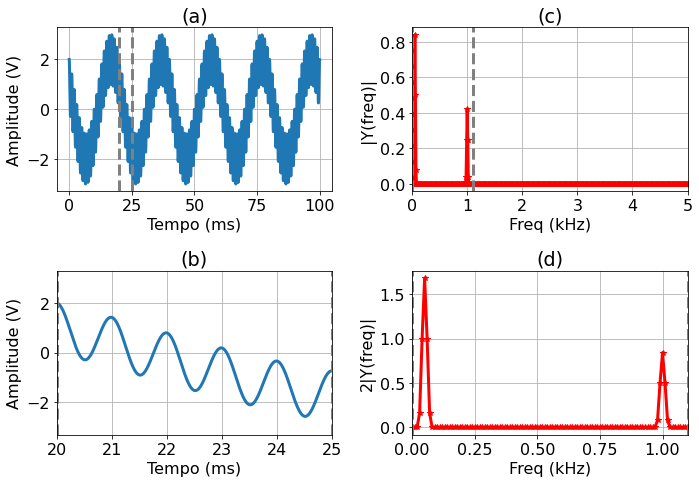

In [124]:
### gráfico com 4 eixos###
fig, ax = plt.subplots(2, 2,figsize=[10,7])
#tempo
ax0 = ax[0,0]
ax0 .plot(1e3*t,v)
ax0 .set_xlabel('Tempo (ms)')
ax0 .set_ylabel('Amplitude (V)')
ax0 .axvline(20,ls='--',c='gray')
ax0 .axvline(25,ls='--',c='gray')
ax0.grid(True)
ax0.set_title('(a)')
#tempo com zoom
ax0 = ax[1,0]
ax0.plot(1e3*t,v)
ax0.set_xlabel('Tempo (ms)')
ax0.set_ylabel('Amplitude (V)')
ax0.set_xlim([20,25])
ax0.grid(True)
ax0.axvline(20,ls='--',c='gray')
ax0.axvline(25,ls='--',c='gray')
ax0.set_title('(b)')
#fft linear - frequencias negativas e positivas
ax0 = ax[0,1]
ax0.plot(freq*1e-3, np.abs(Y),'r*-') # plotting the spectrum
ax0.set_xlabel('Freq (kHz)')
ax0.set_ylabel('|Y(freq)|')
ax0.set_xlim([0,5])
ax0.grid(True)
ax0.axvline(0,ls='--',c='gray')
ax0.axvline(1.1,ls='--',c='gray')
ax0.set_title('(c)')
#fft linear - ZOOM - apenas frequencias positivas
ax0 = ax[1,1]
ax0.plot(freq*1e-3, 2*np.abs(Y),'r*-') # plotting the spectrum
ax0.set_xlabel('Freq (kHz)')
ax0.set_ylabel('|Y(freq)|')
ax0.set_xlim([0,1.1])
ax0.axvline(0,ls='--',c='gray')
ax0.axvline(1.1,ls='--',c='gray')
ax0.grid(True)
ax0.set_title('(d)')
#ajustar e mostrar
plt.tight_layout()
glue("fig_fft1",fig,display=False)

The following graphs show the time signal and also the Fourier transform obtained by the FFT.
```{glue:figure} fig_fft1
:figwidth: 800px
:name: "fig:fft1"
:align: center

(a) Time trace; (b) Zoom of the time trace between the gray dotted lines of (a); (c) Magnitude of the FFT; (d) Magnitude of FFT, zoom between the gray dotted lines of (c)
```

In [ ]:
data_time = pd.read_csv('dados/fft_exemplo_experimental_pa_00_34_22.dat')
glue("df_pandas_fft", data_time.head())

(sec:dataset2)=
### Downloadable dataset 2
* Two-frequencies signals
    * the two `.dat` [files](https://github.com/gwiederhecker/F540_jbook/blob/2021_2s/guides/exp1/dados/two-tones.zip?raw=true) contain oscilloscope time-traces for the input and output of two-frequencies signal going through a LP and HP filter.

````{tabbed} Two-tone oscilloscope trace example
```{glue:figure} df_pandas_fft
:figwidth: 600px
:name: "tbl:pandas2"
:align: center

Structure of the `.csv` data file, the separator between entries is a comma (`,`).
```
````
````{tabbed} Examples oscilloscope screenshot
```{figure} dados/fft_exemplo_experimental_pa.jpeg
---
width: 450px
name: "fig:fft_highpass_scope_exemplo"
---
Screenshot of the two-tone signal measured with the oscilloscope before and after the high-pass filter
```
````

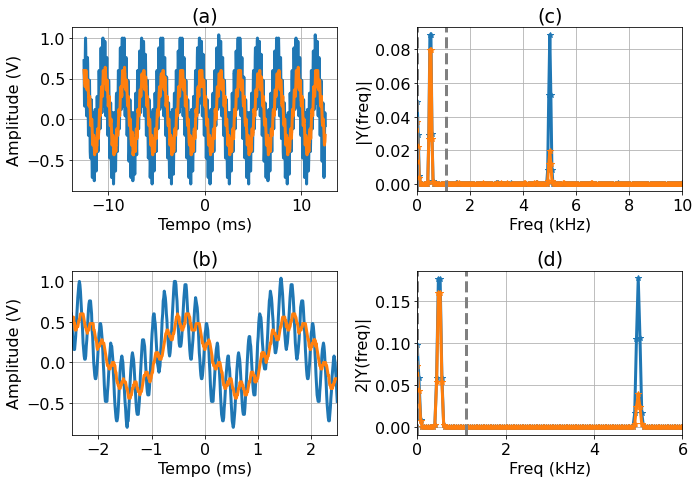

In [115]:
import pandas as pd
data = pd.read_csv('dados/fft_exemplo_experimental_pb_20_13_54.dat',sep='\t')
data.head()
t = data['time (s)']
v1 = data['Channel 1 (V)']
v2 = data['Channel 2 (V)']
freq,Y1 = fft540(t,v1)### gráfico com 4 eixos###
freq,Y2 = fft540(t,v2)### gráfico com 4 eixos###
fig, ax = plt.subplots(2, 2,figsize=[10,7])
#tempo
ax0 = ax[0,0]
ax0 .plot(1e3*t,v1)
ax0 .plot(1e3*t,v2)
ax0 .set_xlabel('Tempo (ms)')
ax0 .set_ylabel('Amplitude (V)')
# ax0 .axvline(20,ls='--',c='gray')
# ax0 .axvline(25,ls='--',c='gray')
ax0.grid(True)
ax0.set_title('(a)')
#tempo com zoom
ax0 = ax[1,0]
ax0 .plot(1e3*t,v1)
ax0 .plot(1e3*t,v2)
ax0.set_xlabel('Tempo (ms)')
ax0.set_ylabel('Amplitude (V)')
ax0.set_xlim([-2.5,2.5])
ax0.grid(True)
# ax0.axvline(20,ls='--',c='gray')
# ax0.axvline(25,ls='--',c='gray')
ax0.set_title('(b)')
#fft linear - frequencias negativas e positivas
ax0 = ax[0,1]
ax0.plot(freq*1e-3, np.abs(Y1),'*-') # plotting the spectrum
ax0.plot(freq*1e-3, np.abs(Y2),'*-') # plotting the spectrum
ax0.set_xlabel('Freq (kHz)')
ax0.set_ylabel('|Y(freq)|')
ax0.set_xlim([0,10])
ax0.grid(True)
ax0.axvline(0,ls='--',c='gray')
ax0.axvline(1.1,ls='--',c='gray')
ax0.set_title('(c)')
#fft linear - ZOOM - apenas frequencias positivas
ax0 = ax[1,1]
ax0.plot(freq*1e-3, 2*np.abs(Y1),'*-') # plotting the spectrum
ax0.plot(freq*1e-3, 2*np.abs(Y2),'*-') # plotting the spectrum
ax0.set_xlabel('Freq (kHz)')
ax0.set_ylabel('2|Y(freq)|')
ax0.set_xlim([0,6])
ax0.axvline(0,ls='--',c='gray')
ax0.axvline(1.1,ls='--',c='gray')
ax0.grid(True)
ax0.set_title('(d)')
#ajustar e mostrar
plt.tight_layout()
glue("fig_fft1",fig,display=False)

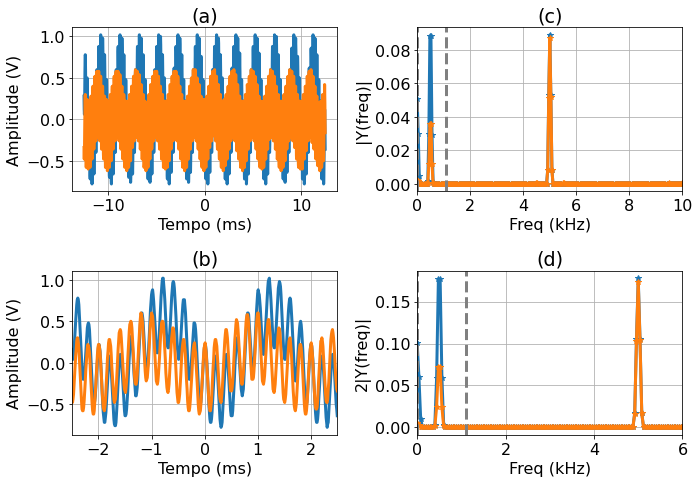

In [120]:
data = pd.read_csv('dados/fft_exemplo_experimental_pa_00_34_22.dat',sep='\t')
data.head()
t = data['time (s)']
v1 = data['Channel 1 (V)']
v2 = data['Channel 2 (V)']
freq,Y1 = fft540(t,v1)### gráfico com 4 eixos###
freq,Y2 = fft540(t,v2)### gráfico com 4 eixos###
fig, ax = plt.subplots(2, 2,figsize=[10,7])
#tempo
ax0 = ax[0,0]
ax0 .plot(1e3*t,v1)
ax0 .plot(1e3*t,v2)
ax0 .set_xlabel('Tempo (ms)')
ax0 .set_ylabel('Amplitude (V)')
# ax0 .axvline(20,ls='--',c='gray')
# ax0 .axvline(25,ls='--',c='gray')
ax0.grid(True)
ax0.set_title('(a)')
#tempo com zoom
ax0 = ax[1,0]
ax0 .plot(1e3*t,v1)
ax0 .plot(1e3*t,v2)
ax0.set_xlabel('Tempo (ms)')
ax0.set_ylabel('Amplitude (V)')
ax0.set_xlim([-2.5,2.5])
ax0.grid(True)
# ax0.axvline(20,ls='--',c='gray')
# ax0.axvline(25,ls='--',c='gray')
ax0.set_title('(b)')
#fft linear - frequencias negativas e positivas
ax0 = ax[0,1]
ax0.plot(freq*1e-3, np.abs(Y1),'*-') # plotting the spectrum
ax0.plot(freq*1e-3, np.abs(Y2),'*-') # plotting the spectrum
ax0.set_xlabel('Freq (kHz)')
ax0.set_ylabel('|Y(freq)|')
ax0.set_xlim([0,10])
ax0.grid(True)
ax0.axvline(0,ls='--',c='gray')
ax0.axvline(1.1,ls='--',c='gray')
ax0.set_title('(c)')
#fft linear - ZOOM - apenas frequencias positivas
ax0 = ax[1,1]
ax0.plot(freq*1e-3, np.abs(Y1),'*-') # plotting the spectrum
ax0.plot(freq*1e-3, np.abs(Y2),'*-') # plotting the spectrum
ax0.set_xlabel('Freq (kHz)')
ax0.set_ylabel('|Y(freq)|')
ax0.set_xlim([0,6])
ax0.axvline(0,ls='--',c='gray')
ax0.axvline(1.1,ls='--',c='gray')
ax0.grid(True)
ax0.set_title('(d)')
#ajustar e mostrar
plt.tight_layout()
glue("fig_fft2",fig,display=False)

<!--
### Propriedades do gerador de RF
* Calcule a impedância que o gerador percebe ao se conectar o circuito passa-baixas no mesmo. Mostre em um gráfico como esta impedância varia como função da frequência (utilize ```plt.semilogx```) 
* Com base na tensão medida no canal de entrada ($V_1$) e o circuito Thevenin da nosso gerador, determine a impedância Thevenin do gerador $R_{Th}$
-->

## Referências